In [2]:
import tensorflow as tf
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
import importlib

In [3]:
import codebase
codebase = importlib.reload(codebase)
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[]

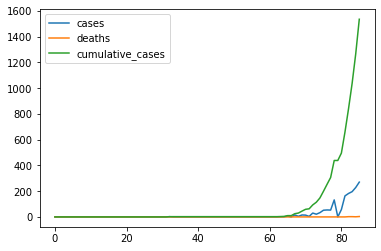

In [64]:
data = pd.read_csv('C:/Users/kipr/Downloads/téléchargement.csv', )
country_data = data[data['geoId'] == 'RU']
country_data.loc[:, 'dateRep'] = pd.to_datetime(country_data['dateRep'], dayfirst=True)
values = country_data.sort_values('dateRep')[['cases', 'deaths']].values

plt.plot(values[:, 0], label='cases')
plt.plot(values[:, 1], label='deaths')
plt.plot(np.cumsum(values[:, 0]), label='cumulative_cases')
plt.legend()
plt.plot()

In [37]:
derivatives, dm, m = make_targets(np.cumsum(values[:, 0]).reshape(-1, 1))
nb_variables = m.shape[1]
X, nb_funcs = make_polynomials(m, max_degree=3)
weights, iterations = sparse_regression(X, derivatives, cutoff=1e-15)
variables = ['1', 'x', 'y']
loss = tf.keras.metrics.MeanSquaredError()

metrics = {'iterations':[iterations],
           'examples':[len(derivatives)],
           'loss':[loss(dm, tf.matmul(X, weights))]} # tf.matmul(X, weights)
params = [[reduce(''.join(name), variables)] + list(val)
          for name, val in zip(combinations_with_replacement(variables[:1 + nb_variables], 5), weights.numpy())]
print(tabulate(metrics, headers=metrics.keys(), tablefmt="pipe"))
print()
print(tabulate(params, headers=['function'] + [f'$\dot{{var}}$' for var in variables[1:]], tablefmt="pipe"))

|   iterations |   examples |        loss |
|-------------:|-----------:|------------:|
|            0 |         89 | 3.31527e+09 |

| function   |   $\dot{var}$ |
|:-----------|--------------:|
| $1$        |   5.05648e-15 |
| $ x$       |   1.73003e-10 |
| $ x^2$     |   5.04417e-06 |
| $ x^3$     |  -6.25159e-11 |


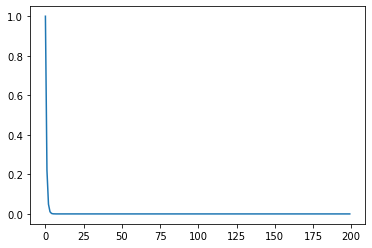

In [36]:
def naive_integrate(weights,
                    initial_state,
                    timesteps=200):
    states = [np.array(initial_state)]
    for k in range(timesteps-1):
        new_state, _ = make_polynomials(states[k], max_degree=3)
        states.append(tf.matmul(new_state.reshape(1, -1), weights).numpy().reshape(-1))
    return np.array(states, dtype=np.float32)

guess = naive_integrate(weights, np.array([1]).reshape(-1))
plt.plot(guess[:, 0])
plt.show()

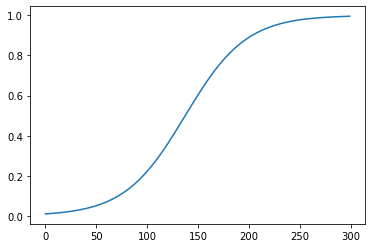

In [12]:
from scipy.integrate import solve_ivp

sigmoid = lambda t, x: 30*x*((1 - x)/6000)

t = np.linspace(0, 2000, 300)

res = solve_ivp(sigmoid, (t[0], t[-1]), [0.01], t_eval=t)
simulated = res['y']
plt.plot(simulated[0])
plt.show()

In [38]:
derivatives, dm, m = make_targets(simulated.reshape(-1, 1))
derivatives = derivatives/t[1]
nb_variables = m.shape[1]
X, nb_funcs = make_polynomials(m, max_degree=3)
weights, iterations = sparse_regression(X, dm, cutoff=1e-3)
variables = ['1', 'x', 'y']
loss = tf.keras.metrics.MeanSquaredError()

metrics = {'iterations':[iterations],
           'examples':[len(dm)],
           'loss':[loss(derivatives, tf.matmul(X, weights))]} # tf.matmul(X, weights)
params = [[reduce(''.join(name), variables)] + list(val)
          for name, val in zip(combinations_with_replacement(variables[:1 + nb_variables], 5), weights.numpy())]
print(tabulate(metrics, headers=metrics.keys(), tablefmt="pipe"))
print()
print(tabulate(params, headers=['function'] + ['$\dot{' + str(var) + '}$' for var in variables[1:]], tablefmt="pipe"))

|   iterations |   examples |       loss |
|-------------:|-----------:|-----------:|
|            2 |        298 | 0.00185444 |

| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |   0         |
| $ x$       |   1.04271   |
| $ x^2$     |  -0.0442875 |
| $ x^3$     |   0         |


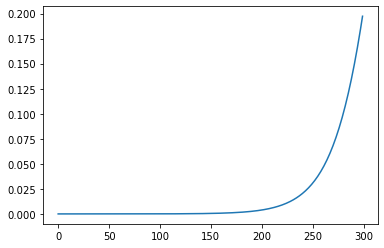

In [25]:
from scipy.integrate import solve_ivp

sigmoid = lambda t, x: 30*x*((1 - x)/6000)

t = np.linspace(0, 2500, 300)

res = solve_ivp(sigmoid, (t[0], t[-1]), [0.000001], t_eval=t)
simulated = res['y']
plt.plot(simulated[0])
plt.show()

In [27]:
derivatives, dm, m = make_targets(simulated.reshape(-1, 1))
derivatives = derivatives/t[1]
nb_variables = m.shape[1]
X, nb_funcs = make_polynomials(m, max_degree=3)
weights, iterations = sparse_regression(X, derivatives, cutoff=1e-3)
variables = ['1', 'x', 'y']
loss = tf.keras.metrics.MeanSquaredError()

metrics = {'iterations':[iterations],
           'examples':[len(derivatives)],
           'loss':[loss(derivatives, tf.matmul(X, weights))]} # tf.matmul(X, weights)
params = [[reduce(''.join(name), variables)] + list(val)
          for name, val in zip(combinations_with_replacement(variables[:1 + nb_variables], 5), weights.numpy())]
print(tabulate(metrics, headers=metrics.keys(), tablefmt="pipe"))
print()
print(tabulate(params, headers=['function'] + ['$\dot{' + str(var) + '}$' for var in variables[1:]], tablefmt="pipe"))

|   iterations |   examples |       loss |
|-------------:|-----------:|-----------:|
|            1 |        298 | 1.9301e-14 |

| function   |   $\dot{x}$ |
|:-----------|------------:|
| $1$        |  0          |
| $ x$       |  0.00500567 |
| $ x^2$     | -0.00503137 |
| $ x^3$     |  0          |


In [62]:
data[['cases', 'dateRep']].groupby(['dateRep']).sum()


,cases
dateRep,
01/01/2020,0
01/02/2020,2120
01/03/2020,1821
02/01/2020,0
02/02/2020,2608
...,...
29/03/2020,65169
30/01/2020,1756
30/03/2020,58520
